In [1]:
import pandas as pd
import pickle
from IPython.display import Image
import numpy as np
from Machine_Learning import kristaps
from matplotlib import pyplot as plt

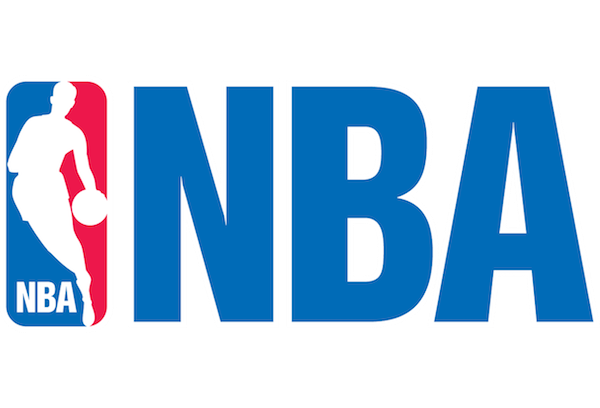

In [2]:
Image(filename='images/logo.png')

# <center>Kristaps</center>

### By Ben Ehlert, Adam Morrow, Michael Proudfoot, and Sterling Suggs

In order to appeal to a wider audience, the National Basketball Association (NBA) has turned to analytics to improve its on court product. Cameras installed in the roofs of the arenas and microchips implanted in player’s uniforms track every step and every bounce of the ball.  The analysis of this and other data has resulted in fundamental shifts in strategy and game planning.  In this project, we are going do perform our own analysis on basketball data from the past 20 years to forecast future game outcomes.

## Data

We will start by reviewing the process by which we collected and constructed our dataset.  We started with a csv file obtained freely from fivethirtyeight.com, containing game information from 1946 to 2015, including the teams involved in each game, the outcome, the date, the game location, and more.  We chose to limit our analysis to the current thirty NBA franchises, and so we discarded all data for games longer than twenty years ago, since that is when the NBA came to its current configuration.  We also dropped some of the more inconsqeuential columns (season or playoffs games) and duplicated games. 

In [3]:
elo = pd.read_csv('data/elo_1946-2015.csv')
elo.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


This csv file was missing about a year and a half of the most recent games, so we scraped this data from basketball-reference.com.  We cleaned this data so that the names for the franchises were consistent between both datasets.

In [4]:
recent_data = pd.read_csv('data/recent_data.csv')
recent_data.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100


The combination of these two datasets, then, gives us all the games with which we are concerned. This is the data that we use to calculate our ELO ratings, an important feature in our model.

In [5]:
historical_data = pd.read_csv('data/historical_data.csv')
historical_data.head()

,fran_id,pts,opp_fran,opp_pts,game_location,date
0,Rockets,120,Hawks,104,A,1976-10-21
1,Celtics,129,Pacers,122,A,1976-10-21
2,Clippers,133,Bucks,112,A,1976-10-21
3,Lakers,97,Knicks,102,A,1976-10-21
4,Bulls,95,Cavaliers,106,A,1976-10-22


### Feature Engineering

##### Points Rolling Average

We hypothesized a rolling average of points would be a useful feature to include in our dataset.  Therefore, we computed the average points each team scored in their last five games.  Then we added the average points that each team allowed in their last five games (that is, the number of points scored by the teams they played against).  Note that while the computation of these depends on the past five games, the result is time-independent, so we can take a random training sample without fear of training on future information.



##### The ELO rating system

The ELO rating system is a method for calculating the relative skill levels of players in two-player games such as chess.  We adapted this system to measure skill levels of different NBA teams based on their recent performance.  We computed the ELO ratings of each team for every game in our dataset.

A team's ELO rating is represented by a number which increases or decreases depending on the outcome of their games. After every game, the winning team takes ELO points from the losing one. The number of points exchanged depends on the  difference in the ELO rating of two teams.  That is, a team that defeats a much better team will gain many points, while a team that defeats a much worse team will only gain a few. 

The ELO rating can serve as a simple predictor of the outcome of a match.  Two teams with equal ratings would be expected to have equal chances of winning (so no real prediction could be made). A team whose rating is 100 points greater than their opponent's has a 64% chance of winning; if the difference is 200 points, then the algorithm gives the stronger player a 76% chance.

To get a better feel for this, we look at an example.

In [6]:
k = kristaps.Kristaps()
k.train_all(pd.read_csv('data/all_games.csv'),write = 0)

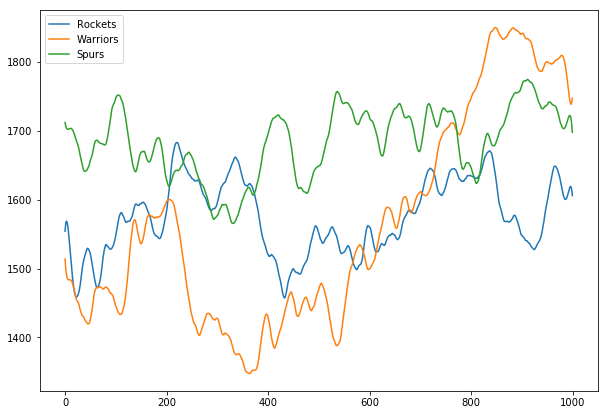

In [7]:
k.plot_Elo(['Rockets', 'Warriors', 'Spurs'], games=1000, window=45, order=5, figsize=(10,7))

This plot tracks the ELO ratings over the last thousand games for the current top three teams in the NBA.  We see how ELO shows the rises and falls of team performance over time. In the short term, teams can go on winning streaks and build up momentum, meaning if they are trending upward sharply, it is more likely they will win the very next game.  We can also observe long-term trends.  For example, the yellow line represents the Golden State Warriors, a team that was not very good nearly a decade ago, but has since risen to be the top team in the league.  Thus ELO provides a very useful feature in training our models because it essentially tells the algorithms if a team is currently 'hot' or 'not'.

Our final dataset takes the following form:

In [8]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename)
data = data[-15000:]  # Training on more than this doesn't seem to improve results, but takes longer
targets = data['Win']
data = data[['fran_elo', 'opp_elo', 'RollAvg_A_5_pts', 'RollAvg_B_5_pts', 'RollAvg_A_5_opp_pts', 'RollAvg_B_5_opp_pts', 'Days_Since_Last']]
data.head()

,fran_elo,opp_elo,RollAvg_A_5_pts,RollAvg_B_5_pts,RollAvg_A_5_opp_pts,RollAvg_B_5_opp_pts,Days_Since_Last
32530,1489.768214,1684.042297,91.8,95.2,96.2,86.8,1.0
32531,1569.508971,1558.067109,83.8,93.2,77.4,84.4,1.0
32532,1687.615767,1528.192875,107.2,98.2,94.2,92.2,1.0
32533,1509.910406,1448.525491,101.2,100.0,106.8,97.6,1.0
32534,1456.563819,1571.171564,97.4,93.6,91.2,83.6,3.0


## Visualizations

This hexbin plot shows the frequency of different scores. The away team's score is generally lower than the home team's score, but both are around 100 on average. We see a line of darker hexes through the middle which represents a tied game, an impossibility in the NBA, where each game must result in one team winning. There is a positive correlation between the two teams. This makes sense, as a team playing a faster tempo will correspondingly give the other team the ball more often and they will both have more opportunities to score points.

Both teams' scores seem to be normally distributed with a mean score of 104-100 for the home team. The standard deviations of both teams' scores are approximately 13 points.

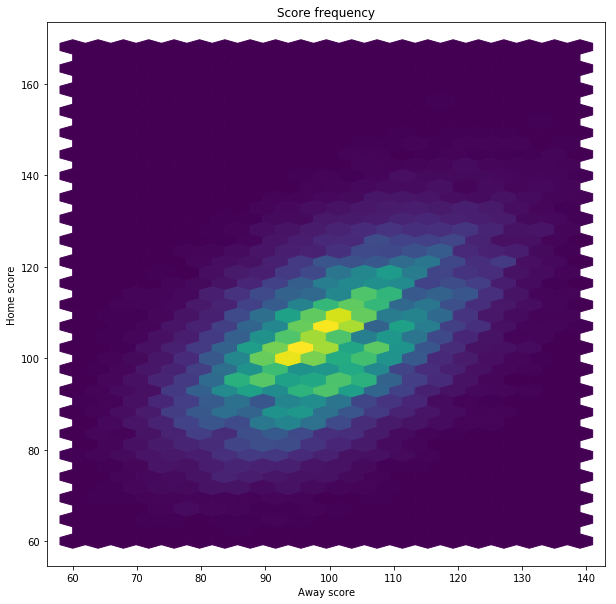

In [9]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename,index_col=None)
data = data.query('pts >= 60 and pts < 140 and opp_pts >= 60 and pts < 140')
plt.figure(figsize=(10,10))
plt.hexbin(data['pts'],data['opp_pts'],gridsize=(20,23))
plt.title('Score frequency')
plt.xlabel('Away score')
plt.ylabel('Home score')
plt.show()

This histogram shows the effects of close games. On the horizontal axis, we have the days since last win for each game played. The bars are colored according to the outcome of the game. The distributions take the same shape, but there are significantly more losses after one day of rest than two. After two days, the team is more likely to win, but after only one, the team is fatigued and is more likely to lose.

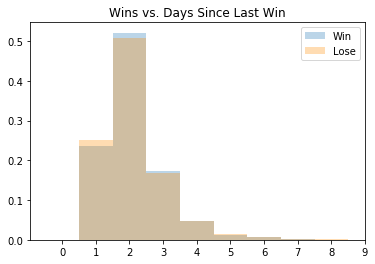

In [10]:
data = pd.read_csv(filename,index_col=None)

plt.hist(data.query('Win == True and Days_Since_Last <= 10')['Days_Since_Last'].dropna().astype(int), alpha=0.3,normed=True,bins=np.arange(0,10)-0.5,label='Win')
plt.hist(data.query('Win == False and Days_Since_Last <= 10')['Days_Since_Last'].dropna().astype(int), color='DarkOrange',alpha=0.3,normed=True,bins=np.arange(0,10)-0.5,label='Lose')
plt.xticks(np.arange(0,10))
plt.title('Wins vs. Days Since Last Win')
plt.legend()
plt.show()

The plot below is a histogram of the margin of victory for the home team.  A positive value indicates that the home team won the game.  Similarly, a negative value means the away team won the game.  Notice that there are no instances where the margin of victory is zero.  In the NBA, teams can't tie.  Games continue in overtime periods until a winner is determined.  Due to home court advantage, the home team is more likely to win than the away team.

Another interesting note is that it is less likely for the margin of victory to be +1 or -1 compared to +2 or -2.  We think this is the case because of the strategy that teams employ at the end of the game if they are losing.  For example, if a team is down by a few points in the last 20 seconds and the opposing team has the ball, then they will foul the leading team to stop the clock.  This causes the winning team to shoot free throws, which the losing team hopes they will miss.  Many times they will make the free throws and be 3 or 4 points ahead instead of 1.

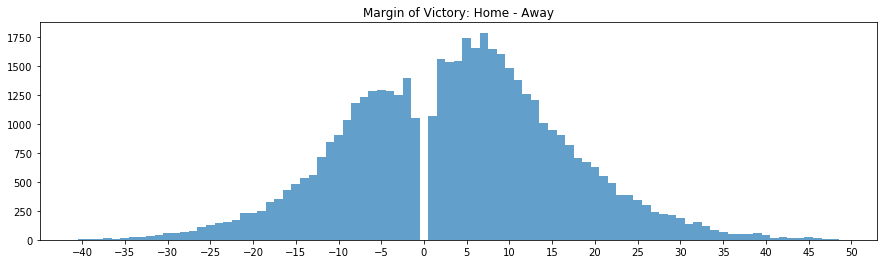

In [11]:
data['margin'] = data['opp_pts'] - data['pts']
plt.figure(figsize=(15,4))
plt.hist(data['margin'],bins=np.arange(-40,50)-0.5,alpha=0.7)
plt.xticks(np.linspace(-40,50,19))
plt.title('Margin of Victory: Home - Away')
plt.show()

In the following hexbins we plot ELO rating against the average points scored and allowed in the last five games.  We expect to see some correlation, since ELO rating is calculated based on wins and losses, and a team is more likely to have won if they scored a greater number points, or allowed fewer.

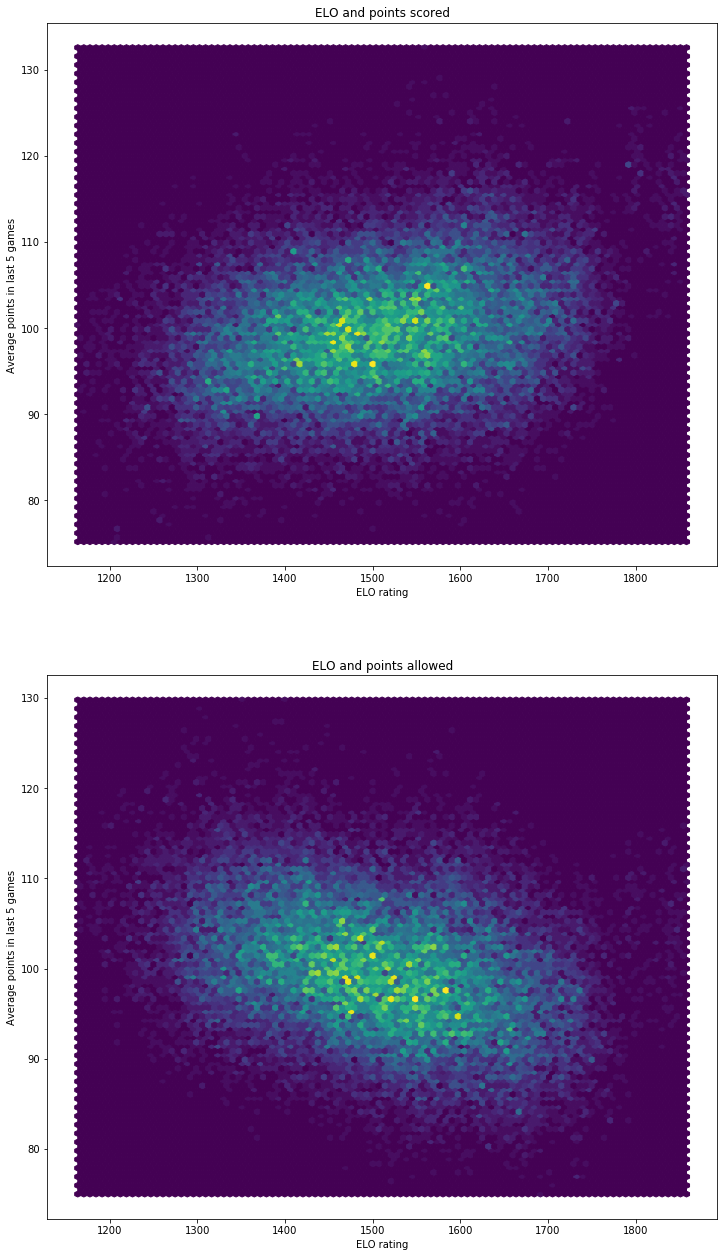

In [12]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename,index_col=None)
data = data[-15000:]
fig, A = plt.subplots(2,1, figsize=(12,22))

temp1 = pd.concat([data['fran_elo'], data['opp_elo']])
temp2 = pd.concat([data['RollAvg_A_5_pts'], data['RollAvg_B_5_pts']])

A[0].hexbin(temp1,temp2)
A[0].set_xlabel('ELO rating')
A[0].set_ylabel('Average points in last 5 games')

temp1 = pd.concat([data['fran_elo'], data['opp_elo']])
temp2 = pd.concat([data['RollAvg_A_5_opp_pts'], data['RollAvg_B_5_opp_pts']])

A[1].hexbin(temp1,temp2)
A[1].set_xlabel('ELO rating')
A[1].set_ylabel('Average points in last 5 games')

A[0].set_title('ELO and points scored')
A[1].set_title('ELO and points allowed')
plt.show()

## Machine Learning

We apply various machine learning techniques to the dataset.  For more information on this data and specific methods, please refer to our Algorithm Discussion page.

In [13]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename)
data = data[-15000:]  # Training on more than this doesn't seem to improve results, but takes longer
targets = data['Win']
data = data[['fran_elo', 'opp_elo', 'RollAvg_A_5_pts', 'RollAvg_B_5_pts', 'RollAvg_A_5_opp_pts', 'RollAvg_B_5_opp_pts', 'Days_Since_Last']]

In [14]:
pd.concat([data.head(), targets.head()], axis=1)

,fran_elo,opp_elo,RollAvg_A_5_pts,RollAvg_B_5_pts,RollAvg_A_5_opp_pts,RollAvg_B_5_opp_pts,Days_Since_Last,Win
32530,1489.768214,1684.042297,91.8,95.2,96.2,86.8,1.0,False
32531,1569.508971,1558.067109,83.8,93.2,77.4,84.4,1.0,False
32532,1687.615767,1528.192875,107.2,98.2,94.2,92.2,1.0,False
32533,1509.910406,1448.525491,101.2,100.0,106.8,97.6,1.0,False
32534,1456.563819,1571.171564,97.4,93.6,91.2,83.6,3.0,False


In our research into different machine learning algorithms, we decided that the most effective types were regression and tree-based algorithms. We use these methods to predict which team will win, and then compare those predictions against the actual result.  Below is a table of the methods used along with accuracy and time.

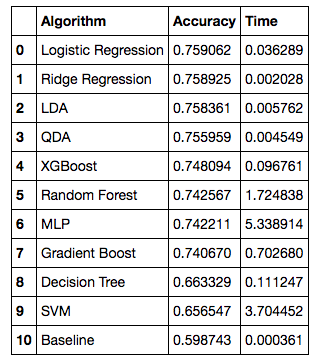

In [15]:
Image(filename='images/algotable.png')

Below is a histogram of all methods used.  Some are better than others.  We decided to include all the methods on the same graph to compare all the methods at once.  If you only look at the top four methods, they are nearly identical.

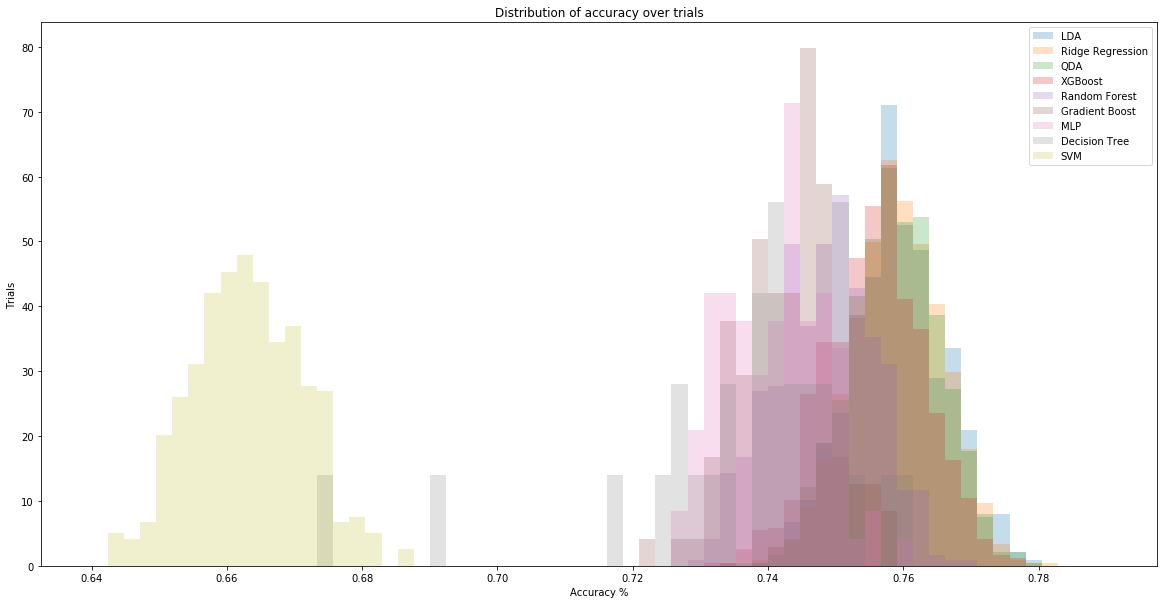

In [16]:
Image(filename='images/algorithms.png')

# Conclusion

Basketball game outcomes are very unreliable.  Even a team that has performed well over the last few games can suddenly and inexplicably lose to a team that has been performing poorly.  Due to these anomalies, we feel that 76% accuracy is quite reasonable for this stage of our project.  We hope to improve on this over time by including more features in our data, namely team statistics: free throws, shots attempted, steals, and percentages.

In our research, we have found that it can be very difficult to predict the outcomes of NBA games. This is because of the numerous variables that can go into each game. Home court advantage, distance traveled, time between previous games played, and injuries of players all can contribute into game outcomes. Due to all this variation, we tried our best to pinpoint the most stable and predictive variables in our model. With the best methods and some fine tuning we can still accurately predict games up to 76% of the games. We conclude that tree and regression based methods are the most accurate and also the quickest of all of our methods. Also games played at home provide a significant advantage, this is attributed to crowd support and no travel. When games are played on back to back nights are also a significant disadvantage for the team that is playing on its second night in a row, mostly likely due to fatigue. All of these variables along with our calculated ELO ratings have provided our best results, giving predictions similar to the accuracy of those made by FiveThirtyEight.